# 10-2 트랜스포머로 상품 설명 요약하기

#### 트랜스포머 가계도

* 트랜스포머는 인코더 + 디코더 구조지만, 작업 목적에 따라 인코더만, 디코더만, 또는 둘 다 사용할 수 있음
   -> 이유: 세 구조의 출력은 모두 토큰별 은닉 벡터(hidden vector) 형식이 동일하기 때문입니다.

* 인코더 기반 모델(Encoder-only)
    ✔ 언제 사용? : 입력 문장을 분석하고 하나의 결과를 내는 작업
                    예: 텍스트 분류, 개체명 인식(NER), 문장 유사도(STS)
    ✔ 사용 방식: 인코더 출력에 분류층(MLP) 등을 붙여서 예측 수행

* 인코더-디코더 모델(Encoder–Decoder)
    ✔ 언제 사용?: 입력 시퀀스를 다른 시퀀스로 바꾸는 시퀀스-투-시퀀스(se2seq) 작업
                 예: 번역, 요약, 질문응답(QA)

* 디코더 기반 모델(Decoder-only)
    ✔ 특징: 타임스텝마다 토큰을 하나씩 생성하는 구조
    ✔ 언제 사용? : 생성 중심 작업

* 요약 한 줄: 트랜스포머는 구조별 출력 형식이 같아서 작업 목적에 따라 인코더만, 디코더만, 인코더-디코더 구조로 다양하게 응용할 수 있다.

#### 전이학습(transfer learning)

* 이미 훈련된 모델을 새로운 작업에 맞춰 재사용하거나 약간 조정하여 사용하는 방법
* 신경망 모델의 파라미터는 재사용할 수 있는 특징을 가지고 있음
* ex) 합성곱 신경망에서는 합성곱층이 학습한 필터가 다양한 시작적 패턴을 감지하는 역할을 함 -> 이미지데이터셋(imageNet dataset)에 훈련된 신경망 많이 공개
* 베이스 모델(base model): 합성곱 신경망의 마지막 부분에 놓인 한 개 이상의 밀집층을 버리고 입력부터 마지막 합성곱 층까지만 재사용


# BART 모델 소개 

* 메타에서 공개한 트랜스포머 기반의 인코더-디코더 언어모델
* 베이스(base)와 라지(large) 두 가지 버전이 있음
    * 베이스: 인코더와 디코더 블록이 각각 6개씩, 파라미터 수: 1억 2천만개
    * 라지: 인코더와 디코더 브롥이 각각 12개씩, 파라미터 수: 4억개 

    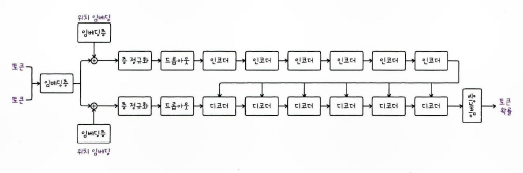

* 위치인코딩(정숫값을 삼각 함수로 위치 정보가 담긴 벡터로 변경)이 아니라 위치임베딩(정숫값을 실수 벡터로) 사용
* 위치임베딩(positional embedding): 토큰을 위한 임베딩 층처럼 위치를 위한 임베딩 층도 처음에는 랜덤하게 초기화되며 훈련을 통해 최적의 값을 학습 
* 디코더 통과 후 마지막 임베딩층
    * 이 층을 통과하면 토큰에 대한 확률 출력
    * 마지막 출력은 임베딩 벡터: BART의 경우 벡터의 크기는 768, 이 벡터로 코튼에 대한 확률 계산
    * BART 모델이 출력할 수 있는 어휘 사전의 토큰 수는 50,265개 -> 768 크기의 벡터를 50,265개의 확률을 담은 또 또 다른 벡터로 바꾸는 작업이 필요

    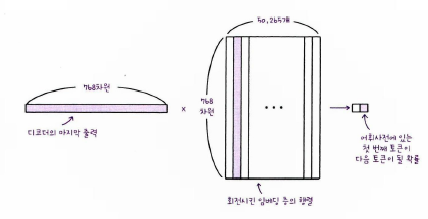

    *  맨 처음 토큰이 들어오는 임베딩 층에는 50,265개의 토큰에 대한 단어 임베딩이 이미 학습 됨 -> 이 행렬을 회전시키면 768*50,265의 모델 파라미터를 얻을 수 있음
    * 이 임베딩 층의 모델 파라미터를 사용해 디코더의 출력 벡터를 각 토큰에 대한 확률로 변경 가능, 즉 새로운 모델 파라미터를 생성하지 않고 첫 단의 임베딩 층의 모델 파라미터를 재사용

#### BART의 인코더와 디코더

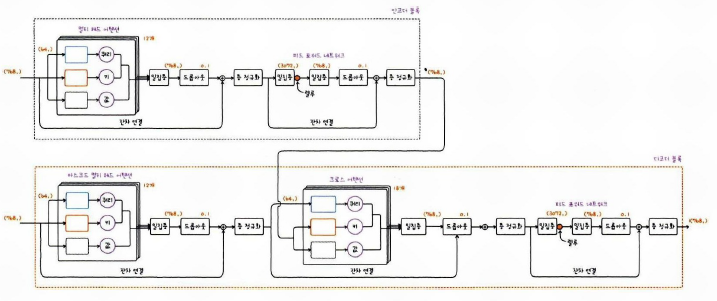

* BART 트랜스포머의 인코더와 디코더 구조는 원본 트랜스포머의 구조와 비슷
* 차이점: 피드포워드 네크워크에서 렐수 활성화 함수 대신 젤루(GeLU) 함수 사용

* 기타
    * BART는 드롭아웃 층을 사용하지만 최신 LLM은 모델과 데이터셋이 커서 여러 에포크 동안 훈련하기 힘듦. 그래서 과대적합을 막기위한 드롭아웃 층을 잘 사용하지 않음
    * BART를 비롯해 많은 트랜스포머 모델에서 피드포워드 네트워크 첫 번째 밀집층의 크기가 임베딩 벡터 크기의 네배 (항상은 아님)

In [2]:
from transformers import pipeline
pipe = pipeline(task='summarization',
                model='sshleifer/distilbart-cnn-12-6',
                device=0,
                framework="pt" )

#No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and
#revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
#Using a pipeline without specifying a model name and revision in production
#is not recommended.

2025-12-03 12:38:03.681016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 12:38:03.757262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 12:38:05.636719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


ValueError: Could not load model sshleifer/distilbart-cnn-12-6 with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForSeq2SeqLM'>, <class 'transformers.models.bart.modeling_bart.BartForConditionalGeneration'>). See the original errors:

while loading with AutoModelForSeq2SeqLM, an error is thrown:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/pipelines/base.py", line 293, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4962, in from_pretrained
    config, dtype, dtype_orig = _get_dtype(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1250, in _get_dtype
    state_dict = load_state_dict(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 508, in load_state_dict
    check_torch_load_is_safe()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1647, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/pipelines/base.py", line 311, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py", line 604, in from_pretrained
    return model_class.from_pretrained(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 5048, in from_pretrained
    ) = cls._load_pretrained_model(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 5316, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 508, in load_state_dict
    check_torch_load_is_safe()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1647, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

while loading with BartForConditionalGeneration, an error is thrown:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/pipelines/base.py", line 293, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 4962, in from_pretrained
    config, dtype, dtype_orig = _get_dtype(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 1250, in _get_dtype
    state_dict = load_state_dict(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 508, in load_state_dict
    check_torch_load_is_safe()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1647, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/pipelines/base.py", line 311, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 277, in _wrapper
    return func(*args, **kwargs)
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 5048, in from_pretrained
    ) = cls._load_pretrained_model(
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 5316, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/modeling_utils.py", line 508, in load_state_dict
    check_torch_load_is_safe()
  File "/home/user/anaconda3/envs/ai-study/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1647, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434




In [2]:
kobart = pipeline(task='summarization', model = 'EbanLee/kobart-summary-v3', device=0)

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.
Device set to use cuda:0


In [3]:
ko_text = """
하나, '입문자 맞춤형 7단계 구성’을 따라가며 체계적으로 반복하는 탄탄한 학습 설계!
이 책은 데이터 분석의 핵심 내용을 7단계에 걸쳐 반복 학습하면서 자연스럽게 머릿속에 기억되
도록 구성했습니다. ［핵심 키워드］와 ［시작하기 전에］에서 각 절의 주제에 대한 대표 개념을 워
밍업하고, 이론과 실습을 거쳐 마무리에서는 ［핵심 포인트］와 ［확인 문제］로 한번에 복습합니다.
,혼자 공부할 수 있는, 커리큘럼을 그대로 믿고 끝까지 따라가다 보면 데이터 분석 공부가 난생
처음인 입문자도 무리 없이 책을 끝까지 마칠 수 있습니다!
둘, 실제로 일어날 법한 훙미로운 스토리에 담긴 문제를 직접 해결하며 익히는 '진짜’ 데이터 분석!
현장감 넘치는 스토리를 통해 데이터를 다루는 방법을 알려 주어 ’파이썬’과 '데이터’가 낯설어
도 몰입감 있는 학습을 할 수 있도록 구성했습니다. 이 책에서는 API와 웹 스크래핑을 통해 실
제 도서관 데이터와 온라인 서점 웹사이트에서 데이터를 가져오는 등 내 주변에 있는 데이터를 직
접 수집할 수 있는 방법을 가이드합니다. 또한 판다스, 넘파이, 맷플롯립 등 데이터 분석에 유용
한 각종 파이썬 라이브러리를 활용해 보며 코딩 감각을 익히고, 핵심 통계 지식으로 기본기를 탄
탄하게 다질 수 있습니다. 마지막에는 분석을 바탕으로 미래를 예측하는 머신러닝까지 맛볼 수 있
어 데이터 분석의 처음부터 끝까지 제대로 배울 수 있습니다.
셋, ,혼공’의 힘을 실어줄 동영상 강의와 혼공 학습 사이트 지원!
책으로만 학습하기엔 여전히 어려운 입문자를 위해 저자 직강 동영상도 지원합니다. 또한 학습을
하며 궁금한 사항은 언제든지 저자에게 질문할 수 있도록 학습 사이트를 제공합니다. 저자가 질문
하나하나에 직접 답변을 달아 주는 것은 물론, 관련 최신 기술과 정보도 얻을 수 있습니다. 게다
가 혼자 공부하고 싶지만 정작 혼자서는 자신 없는 사람들을 위해 혼공 학습단을 운영합니다. 혼
공 학습단과 함께하면 마지막까지 포기하지 않고 완주할 수 있을 것입니다.
► https://hongong.hanbit.co.kr
► https://github.com/rickiepark/hg-da
넷, 언제 어디서든 가볍게 볼 수 있는 혼공 필수 ［용어 노트］ 제공!
꼭 기억해야 할 핵심 개념과 용어만 따로 정리한 ［용어 노트］룔 제공합니다. 처음 공부하는 사람
들이 프로그래밍을 어려워하는 이유는 낯선 용어 때문입니다. 그러나 어려운 것이 아니라 익숙하
지 않아서 헷갈리는 것이므로, 용어나 개념이 잘 생각나지 않을 때는 언제든 부담 없이 ［용어 노
트］를 펼쳐 보세요. 제시된 용어 외에도 새로운 용어룔 추가하면서 자신만의 용어 노트룔 완성해
가는 과정도 또 다른 재미가 될 것입니다.
"""

kobart(ko_text)

[{'summary_text': "이 책은 데이터 분석의 핵심 내용을 7단계에 걸쳐 반복 학습하면서 자연스럽게 머릿속에 기억되도록 구성했습니다. 현장감 넘치는 스토리를 통해 데이터를 다루는 방법을 알려 주어 ’파이썬’과 '데이터’가 낯설어\n도 몰입감 있는 학습을 할 수 있도록 구성했습니다. 이 책에서는 내 주변에 있는 데이터를 직접 수집할 수 있는 방법을 가이드하고 코딩 감각을 익히고, 핵심 통계 지식으로 기본기를 탄 탄하게 다질 수 있습니다. 마지막에는 분석을 바탕으로 머신러닝까지 맛볼 수 있어 데이터 분석의 처음부터 끝까지 제대로 배울 수 있습니다. 끝으로 혼공 학습단과 함께하면 마지막까지 포기하지 않고 완주할 수 있을 것입니다. "}]

# 텍스트 토큰화
* 토큰화는 텍스트를 토큰이라는 단위로 분할하는 과정
* 토큰화는 LLM 모델 자체가 수행하지 않음
* 토크나이저(tokenizer): 토큰화를 수행하는 모델 
* 부분단어(subword): 단어보다 더 작은 부분단어 토큰화 방식이 트랜스포머 기반 LLM에서 널리 사용
* 대표적인 부분단어 토큰화 방법: BPE(Byte-Pair encoding), 워드피스(WordPiece), 유니그램(Unigram), 센텐스피스(SentencePiece)

In [4]:
# BPE : 단어를 문자 단위로 분해하여 어휘 사전에 추가 한 후, 가장 많이 등장하는 순서대로 문자쌍을 찾아 병합, 합쳐진 부분단어를 어휘 사전에 추가 -> 정해진 어휘 사전 크기에 도달할때까지 계속 진행
# BPE는 유니코드 문자를 처리할때 문제가 발생(어휘 사전의 크기 커짐->임베딩 커짐 -> 모델 파라미터 개수 증가)
# 바이트 수준 BPE(byte-level BPE): 텍스트를 바이트 스트림으로 인식하고 자주 등장하는 바이트쌍을 어휘사전에 추가하는 형식, 유니코드 문자도 바이트 수준에서 병합하여 어휘사전에 추가

print(kobart.tokenizer.vocab_size)

30000


In [5]:
len(kobart.tokenizer)

30000

In [6]:
vocab = kobart.tokenizer.vocab
len(vocab)

30000

In [7]:
# 출력을 리스트로 바꿔서 토큰과 토큰아이디 확인 

list(vocab.items())[:10]

[('뚯', 10150),
 ('就', 3499),
 ('补', 7330),
 ('볕', 10880),
 ('휡', 13795),
 ('曳', 4523),
 ("▁있다'고", 24246),
 ('鎌', 8256),
 ('▁보조금', 25944),
 ('▁대답을', 29275)]

In [8]:
# tokenize() method로 토큰 나누기
tokens = kobart.tokenizer.tokenize('혼자 만들면서 공부하는 딥러닝')
print(tokens)

['▁혼자', '▁만들', '면서', '▁공부', '하는', '▁', '딥', '러', '닝']


In [9]:
# 토큰 id 얻기 
kobart.tokenizer.convert_tokens_to_ids(tokens)

[16814, 14397, 14125, 16962, 14049, 1700, 10021, 10277, 9747]

In [10]:
# encode() 문자열에서 토큰 아이디 리스트로 
# 출력되는 0과 1은 문자의 시작과 끝
token_id = kobart.tokenizer.encode('혼자 만들면서 공부하는 딥러닝')
print(token_id)

[0, 16814, 14397, 14125, 16962, 14049, 1700, 10021, 10277, 9747, 1]


In [11]:
# 토큰 아이디를 토큰으로 
tokens = kobart.tokenizer.convert_ids_to_tokens(token_id)
print(tokens)

['<s>', '▁혼자', '▁만들', '면서', '▁공부', '하는', '▁', '딥', '러', '닝', '</s>']


In [12]:
# 토큰 리스트를 원래 문자열로 
kobart.tokenizer.decode(token_id)

'<s> 혼자 만들면서 공부하는 딥러닝</s>'